In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [3]:
#Libraries for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#Libraries for formattting and handling text 
import string 
import re

#Library for nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS


#Library for Splitting Dataset
from sklearn.model_selection import train_test_split


#Libraries for NN
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.initializers import Constant, TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy

#Library for evaluation
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# EDA

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print("Number of rows is = ", train.shape[0], " \nNumber of columns is = " , train.shape[1]) 

Number of rows is =  7613  
Number of columns is =  5


## Missing Values

### Plot Missing Values

<Axes: >

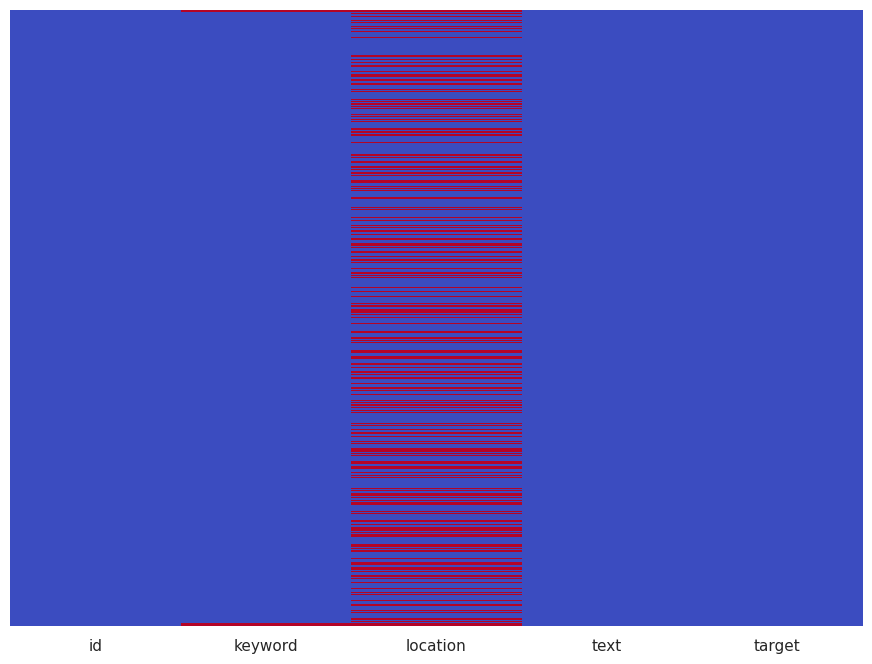

In [6]:
sns.set(rc={'figure.figsize':(11,8)})
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap="coolwarm")

## Traget

### Analyze and Plot Target

In [7]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

Text(0.5, 1.0, 'Target Distributions \n (0: Non Disaster || 1: Disaster)')

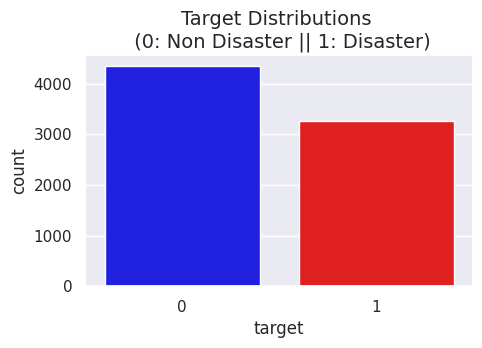

In [8]:
plt.figure(figsize=(5,3))
colors = ["blue", "red"]

sns.countplot(x = 'target', data=train, palette=colors)
plt.title('Target Distributions \n (0: Non Disaster || 1: Disaster)', fontsize=14)

## Keywords

In [9]:
train["keyword"].nunique()

221

### Plot Top 20 Keywords

Text(0.5, 0, 'Count of Keywords')

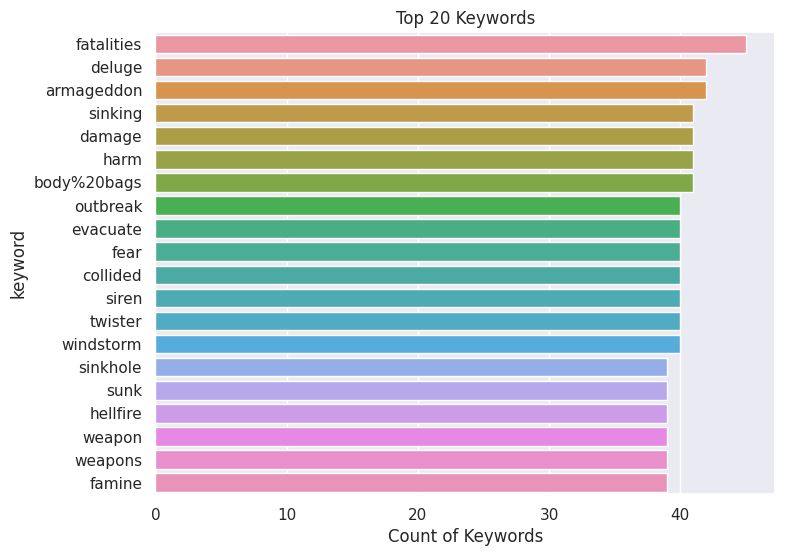

In [10]:
plt.figure(figsize=(8,6))
chains=train['keyword'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index)
plt.title("Top 20 Keywords")
plt.xlabel("Count of Keywords")

### Plot Top 20 Disaster and Non-disaster Keywords

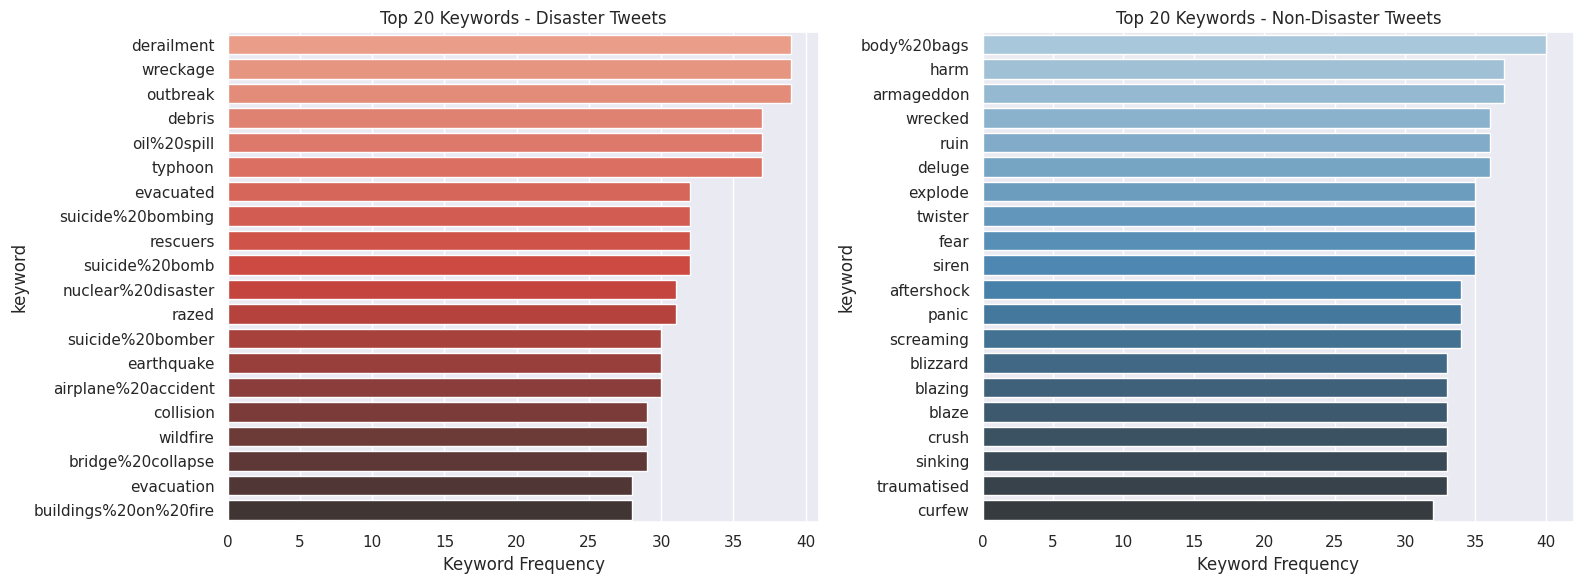

In [11]:
disaster_keywords = train.loc[train["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = train.loc[train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

In [12]:
top_disaster_keyword = train.groupby('keyword')['target'].mean().sort_values(ascending = False).head(20)
top_nondisaster_keyword = train.groupby('keyword')['target'].mean().sort_values().head(20)

## Location

In [13]:
locations = train["location"].value_counts()

### Plot Top 20 Locations

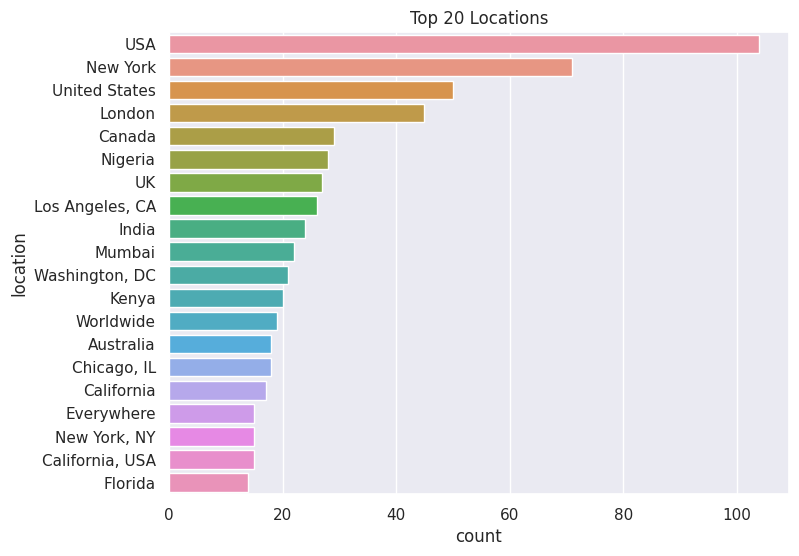

In [14]:
plt.figure(figsize=(8,6))


sns.barplot(y=locations[0:20].index, x=locations[0:20], orient='h')

plt.title("Top 20 Locations")
plt.show()

## Text

In [15]:
train["length"]  = train["text"].apply(len)
train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [16]:
train['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

### Plot Tweets Character Length

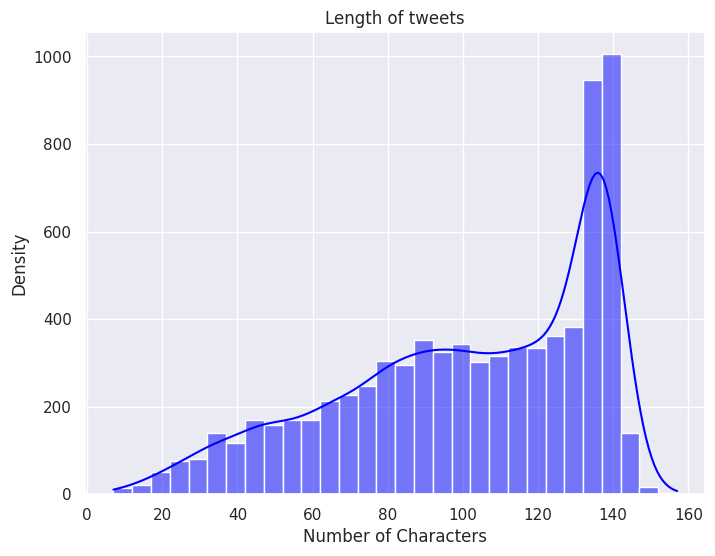

In [17]:
plt.figure(figsize=(8,6))
sns.histplot(train["length"], kde=True,color='blue',bins=30)
plt.title("Length of tweets")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

### Plot Tweets Character Length with Target

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

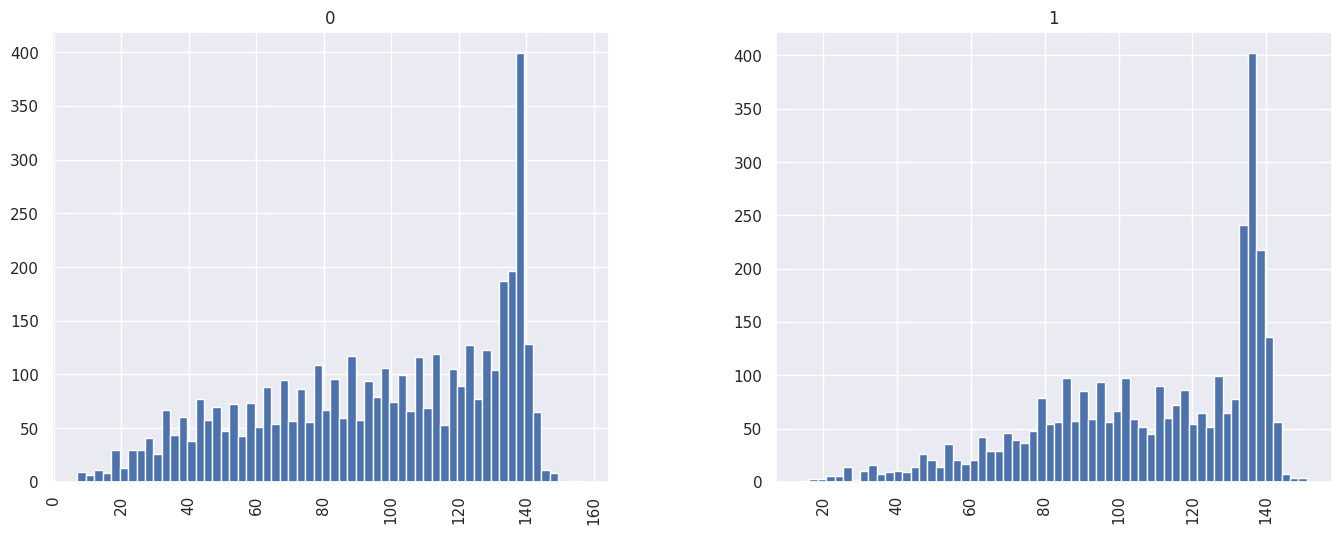

In [18]:
train.hist(column='length', by = 'target',bins =60, figsize= (16,6))

### Plot Number of Words in Tweets

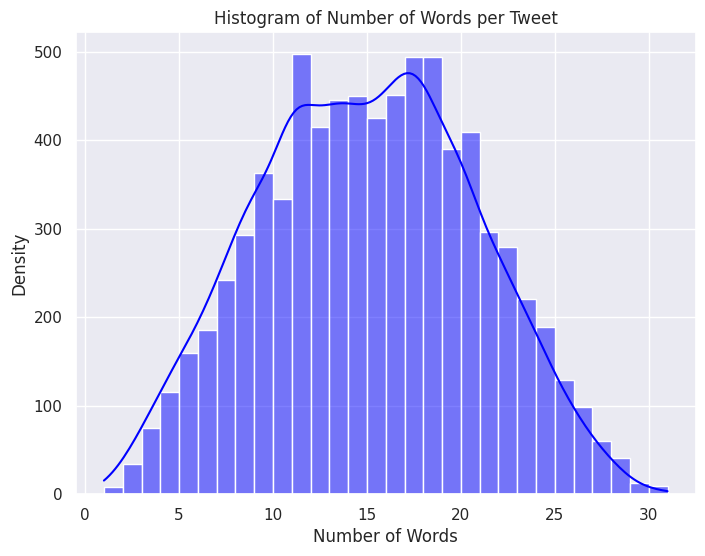

In [19]:
def count_words(x):
    return len(x.split())

train["num_words"] = train["text"].apply(count_words)

plt.figure(figsize=(8,6))
sns.histplot(train["num_words"],kde=True,color='blue',bins=30)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

### Plot Number of Words in Tweets with Target

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

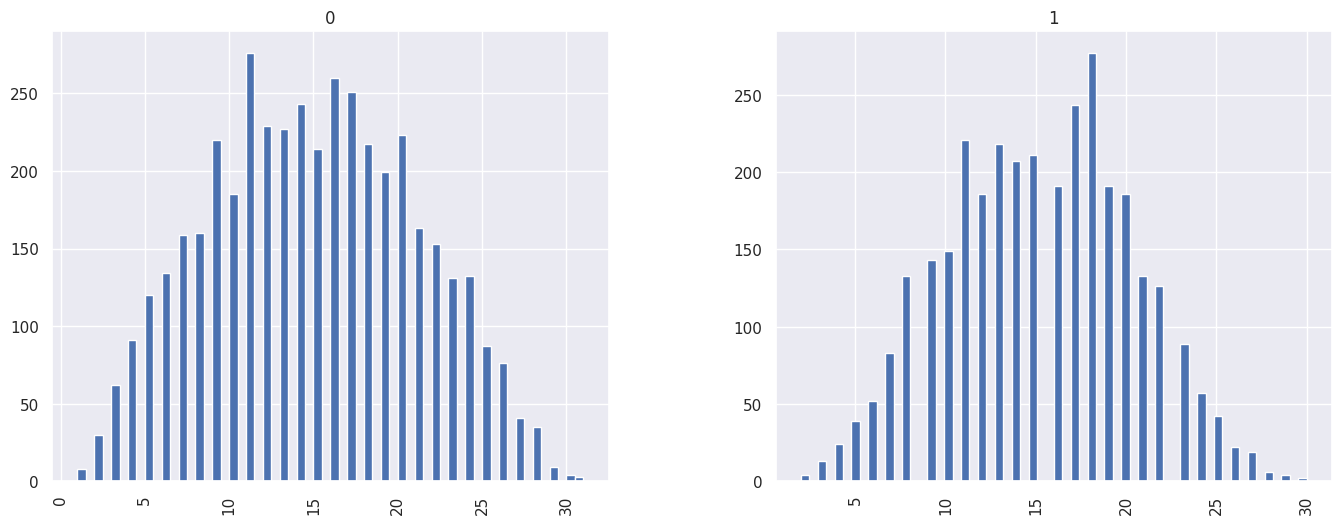

In [20]:
train.hist(column='num_words', by = 'target',bins =60, figsize= (16,6))

# LSTM

## Data Processing

### Remove Noise

In [57]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [58]:
# Remove punctuation
def remove_punctuation(text):
    clean_text = [char for char in text if char not in string.punctuation]
    clean_text = ''.join(clean_text)      
    return clean_text

# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?:\/\/t.co\/[A-Za-z0-9]+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>+')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [59]:
def clean_tweet(text):
 
    # Remove non text
    text = remove_punctuation(text)
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # replace abbreviations, @ and number
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
  
    return text

In [60]:
train["clean_text"] = train["text"].apply(clean_tweet)

In [61]:
train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,just got sent this photo from ruby alaska as s...


### Remove Stopwords

In [62]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [63]:
def remove_stopwords(text):
    # Tokenize the input text and remove stopwords
    words = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    # Join the remaining words into a single string
    clean_text = ' '.join(words)
    return clean_text

In [64]:
train["clean_text"] = train["clean_text"].apply(remove_stopwords)

In [65]:
train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,got sent photo ruby alaska smoke wildfires pou...


### Lowercase

Keras tokenizer can convert texts to lowercase.

### Tokenization

####  Word Corpus and Embedding Dictionary

In [66]:
# Creating Words Corpus

def create_corpus(dataset):
    corpus = []
    for review in tqdm(dataset['clean_text']):
        words = [ word.lower() for word in word_tokenize(review) if (word.isalpha() == 1 ) ]
        corpus.append(words)

    return corpus

corpus = create_corpus(train)

100%|██████████| 7613/7613 [00:01<00:00, 5559.87it/s]


In [67]:
# Creating Embedding Dictionary

embedding_dict={}
with open('../input/glove6b100dtxt/glove.6B.100d.txt','r', encoding='utf8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [68]:
# Tokenize : break the sentence into single word/token
# texts_to_sequences : convert tokenized word into an encoded sequnce
# pad_sequence : change the length of sequence by either adding or truncating

MAX_LEN = 30 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_sequences(corpus)

corpus_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [69]:
# Unique words present
word_index = tokenizer.word_index
print(f"Number of unique words : {len(word_index)}")

Number of unique words : 14891


In [70]:
# Creating embedding matrix with GloVe using enbedding_dict we created above
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 14891/14891 [00:00<00:00, 317752.24it/s]


In [71]:
X_train,X_val,y_train,y_val = train_test_split(corpus_pad, train['target'].values, test_size = 0.25, random_state = 42)

print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)

print('Shape of train',y_train.shape)
print("Shape of Validation ",y_val.shape)

Shape of train (5709, 30)
Shape of Validation  (1904, 30)
Shape of train (5709,)
Shape of Validation  (1904,)


## Model Training

In [72]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

optimizer = Adam(learning_rate=2e-3)
loss = BinaryCrossentropy()

In [73]:
# Long Short Term Memory network.
lstm_out = 64
# We need sequential model to process sequence of text data
model=Sequential()

# Embedding(input_dimension, output_dimension,embeddings_initializer = initialize the embedding matrix we created, trainable = do not train)
embedding=Embedding(num_words,100,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,
                    trainable=False)

# Adding Embedding Layer
model.add(embedding)

# Drops 20% of entire row
model.add(Dropout(0.4))

# Recurrent Layer LSTM(dimensionality of the output space, dropout = 20%, recurrent_dropout = 40%) 
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))

# Decide what we are going to output Dense(units, activation function)
model.add(Dense(1, activation='sigmoid'))

# Compile the model compile(loss = binary crossentropy, use Adam(adaptive moment estimation) optimizer with learning rate 1e-3,evaluate based on accuracy)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', f1_metric])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1489200   
                                                                 
 dropout_38 (Dropout)        (None, 30, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,531,505
Trainable params: 42,305
Non-trainable params: 1,489,200
_________________________________________________________________


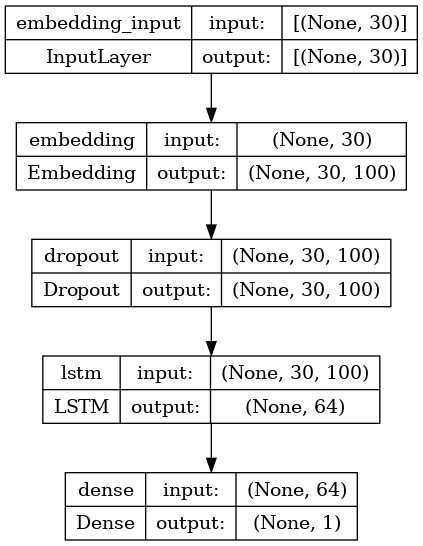

In [29]:
plot_model(model, show_shapes = True)

In [74]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [75]:
history = model.fit(X_train,y_train, batch_size=32, epochs=20, callbacks=[es_callback], validation_data = (X_val,y_val))

Epoch 1/20
179/179 [==============================] - 24s 115ms/step - loss: 0.5367 - accuracy: 0.7381 - f1_metric: 0.6056 - val_loss: 0.4706 - val_accuracy: 0.7967 - val_f1_metric: 0.7236
Epoch 2/20
179/179 [==============================] - 20s 112ms/step - loss: 0.4837 - accuracy: 0.7747 - f1_metric: 0.7092 - val_loss: 0.4648 - val_accuracy: 0.8083 - val_f1_metric: 0.7735
Epoch 3/20
179/179 [==============================] - 20s 112ms/step - loss: 0.4786 - accuracy: 0.7840 - f1_metric: 0.7225 - val_loss: 0.4431 - val_accuracy: 0.8120 - val_f1_metric: 0.7636
Epoch 4/20
179/179 [==============================] - 20s 113ms/step - loss: 0.4647 - accuracy: 0.7851 - f1_metric: 0.7151 - val_loss: 0.4331 - val_accuracy: 0.8157 - val_f1_metric: 0.7736
Epoch 5/20
179/179 [==============================] - 20s 112ms/step - loss: 0.4619 - accuracy: 0.7924 - f1_metric: 0.7278 - val_loss: 0.4383 - val_accuracy: 0.8172 - val_f1_metric: 0.7751
Epoch 6/20
179/179 [==============================] - 2

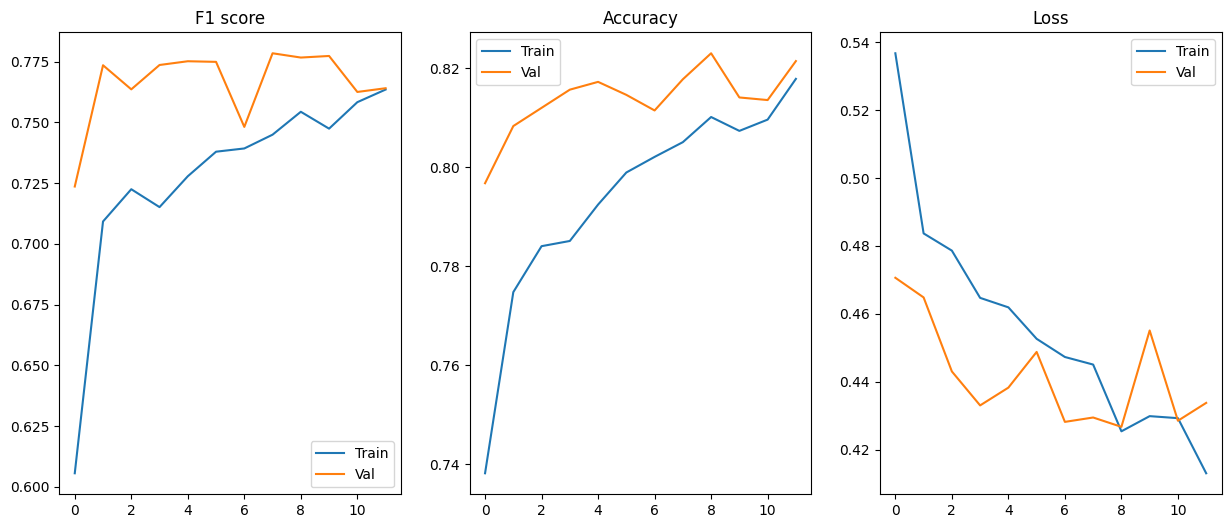

In [76]:
# plot the performance curve
epochs = history.epoch
plt.figure(figsize=(15, 6))

# F1
plt.subplot(1,3, 1)
plt.plot(epochs, history.history['f1_metric'], label="Train")
plt.plot(epochs, history.history['val_f1_metric'], label = "Val")
plt.legend()
plt.title("F1 score")

# Accuracy
plt.subplot(1,3, 2)
plt.plot(epochs, history.history['accuracy'], label="Train")
plt.plot(epochs, history.history['val_accuracy'], label = "Val")
plt.legend()
plt.title("Accuracy")

# loss
plt.subplot(1,3, 3)
plt.plot(epochs, history.history['loss'], label="Train")
plt.plot(epochs, history.history['val_loss'], label = "Val")
plt.legend()
plt.title("Loss")

plt.show()

In [77]:
y_pred = model.predict(X_val).round()

60/60 [==============================] - 1s 10ms/step


In [78]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1091
           1       0.87      0.69      0.77       813

    accuracy                           0.82      1904
   macro avg       0.83      0.80      0.81      1904
weighted avg       0.83      0.82      0.82      1904



## Prediction

In [24]:
test['clean_text'] = test['text'].apply(clean_tweet)
test["clean_text"] = test["clean_text"].apply(remove_stopwords)

In [25]:
# Creating corpus
test_corpus = create_corpus(test)

100%|██████████| 3263/3263 [00:00<00:00, 7168.33it/s]


In [26]:
# Encoding Test Text to Sequences
test_sequences = tokenizer.texts_to_sequences(test_corpus)

test_corpus_pad = pad_sequences(test_sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [27]:
# Predictions
predictions = model.predict(test_corpus_pad)
predictions = np.round(predictions).astype(int).reshape(3263)

102/102 [==============================] - 1s 6ms/step


In [28]:
# Creating submission file 
submission = pd.DataFrame({'id' : test['id'], 'target' : predictions})
#submission.to_csv('submission_LSTM.csv', index=False)

submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


# Bert

## Data Processing

In [5]:
from transformers import BertTokenizer
from transformers import AutoTokenizer
from transformers import TFAutoModel

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [7]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = t.replace("#","")
        new_text.append(t.lower())
    return " ".join(new_text).strip().replace("  ", " ")

In [8]:
train['text'] = train['text'].apply(preprocess)
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [9]:
train['text'].iloc[20]

'this is ridiculous....'

In [10]:
# example of tokenization
tokenizer.tokenize(train['text'].iloc[20])

['this', 'is', 'ridiculous', '.', '.', '.', '.']

In [11]:
# example of an output from encoded text by tokeneizer
encoded_input = tokenizer(train['text'].iloc[20])
print(encoded_input)

{'input_ids': [101, 2023, 2003, 9951, 1012, 1012, 1012, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
tokenizer.decode(encoded_input['input_ids'])

'[CLS] this is ridiculous.... [SEP]'

In [13]:
SEQ_LEN = 30

In [14]:
# encoding the training data
train_encoded_inputs = tokenizer(train['text'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length', 
                                 truncation=True, 
                                 max_length=SEQ_LEN, 
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

### Creating Tensorflow data

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_encoded_inputs, train['target'].values))

In [16]:
# formatting the data as required by bert model
def map_bert(inputs, labels):
    inputs = {'input_ids': inputs['input_ids'],
              'attention_mask': inputs['attention_mask']}
    return inputs, labels

In [17]:
train_dataset = train_dataset.map(map_bert)

### Creating Train and Validation Split

In [18]:
dataset = train_dataset.shuffle(100000).batch(64)

In [19]:
# length of the dataset(total batches)
DS_LEN = len(dataset)
DS_LEN

119

In [20]:
# take 80% for train and 20% for validation
SPLIT = 0.8
train_ds = dataset.take(round(DS_LEN*SPLIT))
val_ds = dataset.skip(round(DS_LEN*SPLIT))

## Model Training

In [21]:
bert = TFAutoModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [22]:
# create model architecture
#n_classes = len((train_df.target.unique()))

# Input layers
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name='input_ids' )
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name = 'attention_mask')

# bert embeddings
embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:,0,:]

# keras layers
#x = tf.keras.layers.GlobalMaxPool1D()(embeddings)
x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

# output layer
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                            

In [24]:
# freezing the pretrained bert layer
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                            

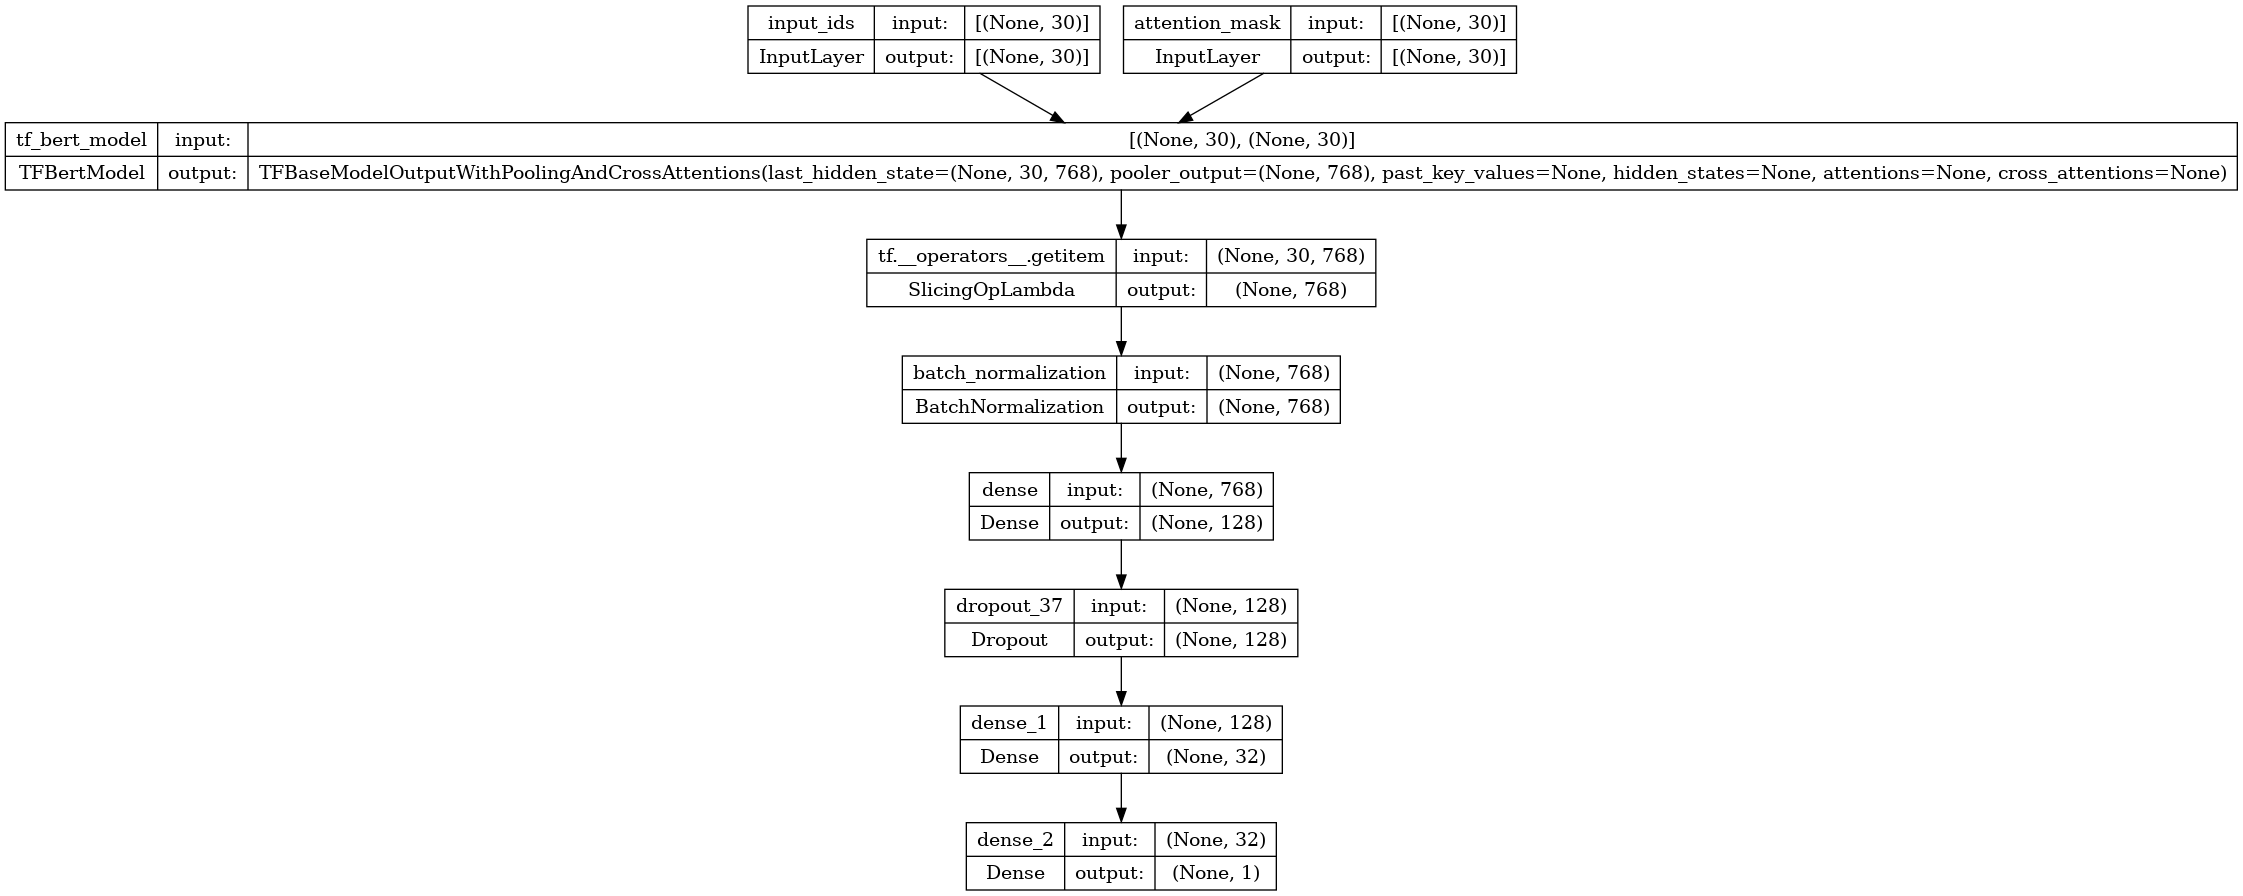

In [25]:
plot_model(model, show_shapes = True)

### Compile model

In [41]:
#learning_rate = 1e-3

optimizer = Adam(learning_rate=5e-4)
#optimizer = transformers.AdamWeightDecay(learning_rate=5e-4)
loss = BinaryCrossentropy()
#metric = BinaryAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', f1_metric])

In [45]:
# train the model
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1,min_delta=0.001,monitor='val_loss'),
             tf.keras.callbacks.EarlyStopping(patience=2, min_delta=0.001, monitor='val_loss')]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks
)

Epoch 1/50
95/95 [==============================] - 11s 117ms/step - loss: 0.3567 - accuracy: 0.8449 - f1_metric: 0.8034 - val_loss: 0.2564 - val_accuracy: 0.9022 - val_f1_metric: 0.8771 - lr: 5.0000e-09
Epoch 2/50
95/95 [==============================] - 11s 117ms/step - loss: 0.3499 - accuracy: 0.8482 - f1_metric: 0.8089 - val_loss: 0.2739 - val_accuracy: 0.8969 - val_f1_metric: 0.8751 - lr: 5.0000e-09
Epoch 3/50
95/95 [==============================] - 11s 117ms/step - loss: 0.3471 - accuracy: 0.8523 - f1_metric: 0.8165 - val_loss: 0.2505 - val_accuracy: 0.9093 - val_f1_metric: 0.8921 - lr: 5.0000e-09
Epoch 4/50
95/95 [==============================] - 11s 117ms/step - loss: 0.3473 - accuracy: 0.8500 - f1_metric: 0.8111 - val_loss: 0.2647 - val_accuracy: 0.8937 - val_f1_metric: 0.8703 - lr: 5.0000e-09
Epoch 5/50
95/95 [==============================] - 11s 117ms/step - loss: 0.3511 - accuracy: 0.8461 - f1_metric: 0.8085 - val_loss: 0.2536 - val_accuracy: 0.9035 - val_f1_metric: 0.88

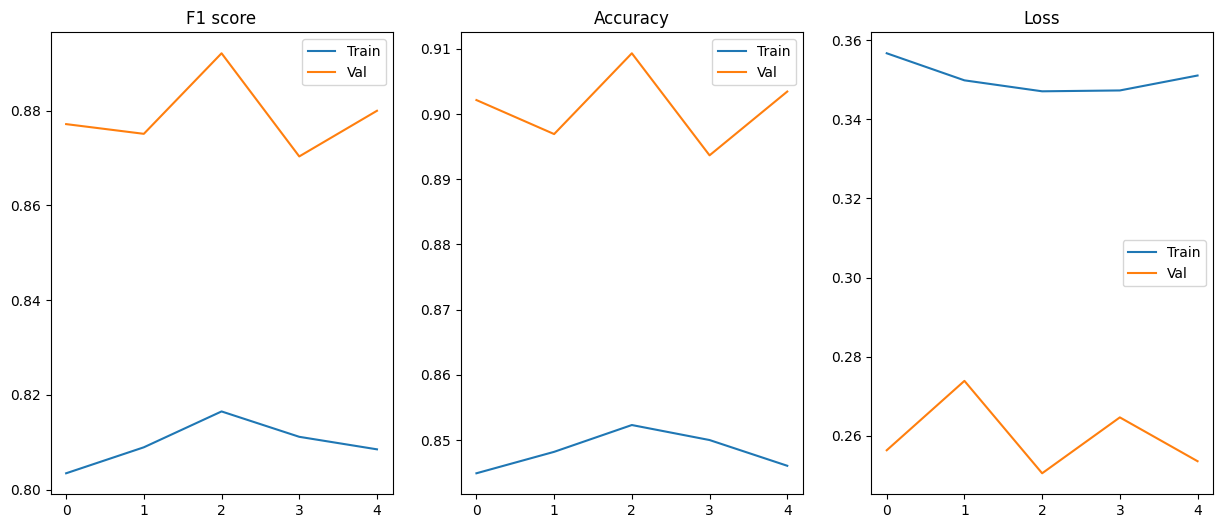

In [46]:
# plot the performance curve
epochs = history.epoch
plt.figure(figsize=(15, 6))

# F1
plt.subplot(1,3, 1)
plt.plot(epochs, history.history['f1_metric'], label="Train")
plt.plot(epochs, history.history['val_f1_metric'], label = "Val")
plt.legend()
plt.title("F1 score")

# Accuracy
plt.subplot(1,3, 2)
plt.plot(epochs, history.history['accuracy'], label="Train")
plt.plot(epochs, history.history['val_accuracy'], label = "Val")
plt.legend()
plt.title("Accuracy")

# loss
plt.subplot(1,3, 3)
plt.plot(epochs, history.history['loss'], label="Train")
plt.plot(epochs, history.history['val_loss'], label = "Val")
plt.legend()
plt.title("Loss")

plt.show()

In [47]:
# evaluate on val data
model.evaluate(val_ds)

24/24 [==============================] - 2s 89ms/step - loss: 0.2704 - accuracy: 0.8982 - f1_metric: 0.8685


[0.27035874128341675, 0.8982387185096741, 0.8685480952262878]

## Prediction

In [48]:
# clean text
test['text'] = test['text'].apply(preprocess)

In [49]:
# encoding the test data
test_encoded_inputs = tokenizer(test['text'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length', 
                                 truncation=True, 
                                 max_length=SEQ_LEN, 
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

In [50]:
# create tf dataset
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encoded_inputs))

In [51]:
# make prediction
test_ds = test_dataset.shuffle(100000).batch(64)
test_pred = model.predict(test_ds)

51/51 [==============================] - 8s 87ms/step


In [52]:
test_pred

array([[0.07468449],
       [0.8931649 ],
       [0.23052068],
       ...,
       [0.9967303 ],
       [0.06068737],
       [0.9999945 ]], dtype=float32)

In [53]:
test.shape

(3263, 4)

In [54]:
# create the target labels for test data
#test_target = np.round(test_pred).flatten()
test_target = np.where(test_pred>0.5,1,0)
test_target = test_target.reshape((1,3263))[0]
test_target

array([0, 1, 0, ..., 1, 0, 1])

In [55]:
test['target'] = test_target.astype('int')
test.head(6)

,id,keyword,location,text,target
0,0,NaN,NaN,just happened a terrible car crash,0
1,2,NaN,NaN,"heard about earthquake is different cities, st...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
3,9,NaN,NaN,apocalypse lighting. spokane wildfires,0
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,0
5,12,NaN,NaN,we're shaking...it's an earthquake,0


In [56]:
# Creating submission file 
submission = pd.DataFrame({'id' : test['id'], 'target' : test_target})
#submission.to_csv('submission_bertii.csv', index=False)

submission.head()

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,0
